# Document Overview
## This file outlines the following procedures:

1. Generating a blank 2D array with a size of 16 rows and 3 columns to store raw reset counts and resets per area for individual channels.
2. Filling the empty array with our specified data.
3. Saving the data array into a CSV file.

In [13]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot
import saq
import glob
import  csv


## Use the function glob() in the glob libary to obtain a list of paths matching a pathname pattern and use sorted() to sort them. Here, we use it for obtaining all root data files.

In [14]:
root_file_paths = sorted(glob.glob('/home/wwz/saq_analysis/calibration/E_scan/*.root'))
#sorted(root_file_paths)
print(root_file_paths)

['/home/wwz/saq_analysis/calibration/E_scan/05_22_2023_09_47_10.root', '/home/wwz/saq_analysis/calibration/E_scan/05_22_2023_10_35_16.root', '/home/wwz/saq_analysis/calibration/E_scan/05_22_2023_11_21_34.root', '/home/wwz/saq_analysis/calibration/E_scan/05_22_2023_12_07_46.root', '/home/wwz/saq_analysis/calibration/E_scan/05_22_2023_12_59_31.root']


In [15]:
print(saq.N_SAQ_CHANNELS)
print(np.arange(10))

16
[0 1 2 3 4 5 6 7 8 9]


## For each root data file:
1. Generate a blank 2D array
2. Fill the following data into the 2D array: 
* column 1: channel numbers 1-16  ()                              
* column 2: resets/area in eah channel                           
* column 3: raw resets in each channel     
3. Save the data arrary into a csv file for each root data file                     


[8, 5, 5, 10, 24, 47, 82, 172, 152, 35, 22, 36, 36, 48, 0, 0]
[[1.00000000e+00 5.67270904e+00 8.00000000e+00]
 [2.00000000e+00 1.08114514e+00 5.00000000e+00]
 [3.00000000e+00 6.33014124e-01 5.00000000e+00]
 [4.00000000e+00 7.15122326e-01 1.00000000e+01]
 [5.00000000e+00 1.06790552e+00 2.40000000e+01]
 [6.00000000e+00 1.68096024e+00 4.70000000e+01]
 [7.00000000e+00 2.32215051e+00 8.20000000e+01]
 [8.00000000e+00 2.76719353e+00 1.72000000e+02]
 [9.00000000e+00 1.10175249e+00 1.52000000e+02]
 [1.00000000e+01 1.97901259e-01 3.50000000e+01]
 [1.10000000e+01 1.00737468e-01 2.20000000e+01]
 [1.20000000e+01 6.58006871e-02 3.60000000e+01]
 [1.30000000e+01 5.13261785e-02 3.60000000e+01]
 [1.40000000e+01 5.48693409e-02 4.80000000e+01]
 [1.50000000e+01 0.00000000e+00 0.00000000e+00]
 [1.60000000e+01 0.00000000e+00 0.00000000e+00]]
[0, 0, 0, 0, 14, 37, 77, 165, 148, 15, 3, 6, 0, 0, 0, 0]
[[1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.00000000e+00 0.00000000e+00 0.00000000e+00]
 [3.00000000e+00

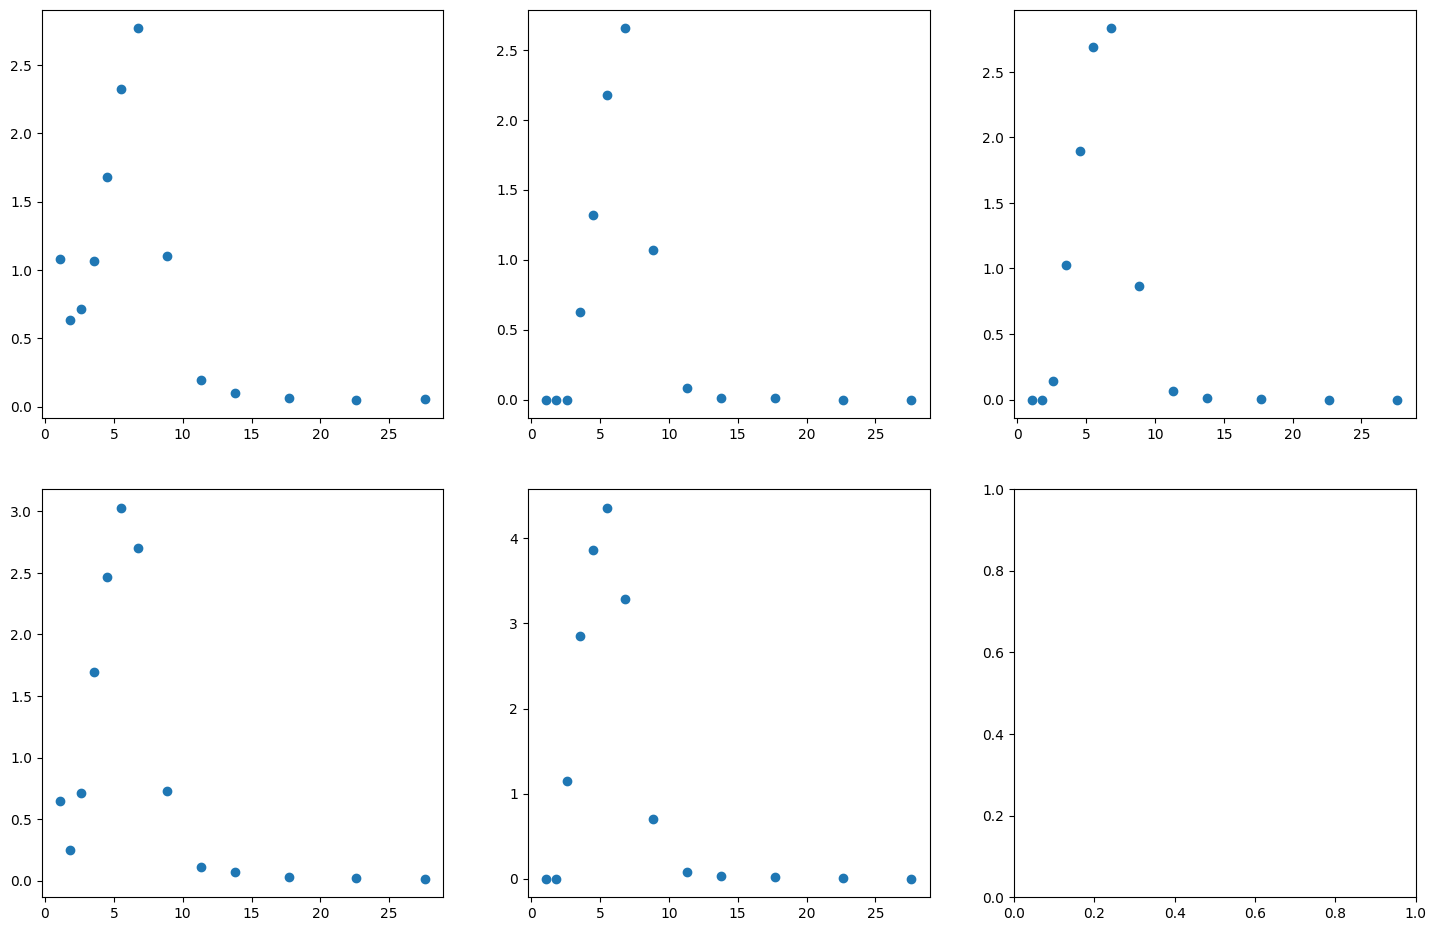

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.tight_layout(pad=3.0)

save_data = np.zeros((saq.N_SAQ_CHANNELS, 3))
save_data[:,0] = np.arange(saq.N_SAQ_CHANNELS)+1  # channel numbers 1-16
    
# Iterate through each root file
for k, root_file_path in enumerate(root_file_paths):
    file = uproot.open(root_file_path)
    #print(root_file_path)

    # Access the tree from the ROOT file
    tree = file["tt"]  # 'tt' is the name of the data tree in the root file

    # Convert the tree data into a dictionary
    data = tree.arrays(library="np")
    # Get timestamps from the data
    timestamps = data["Timestamp"]
    mask = data["ChMask"]
    pid = data["pid"]
    #print(pid[:10])
    #print(len(pid))
    #print(len(mask))
    filtered_pid = [pid[i] for i in range(len(timestamps)) if pid[i] != min(pid)]
    filtered_mask = [mask[i] for i in range(len(timestamps)) if mask[i] !=0 and pid[i] != min(pid)]

    #print(len(filtered_pid))
    #print(len(filtered_mask))
    
    ch_resets = [] # store all resets for all channels
    
    for i in range(len(filtered_mask)):
        #print(saq.channels_in_reset_mask(filtered_mask[i]))
        for j in range(len(saq.channels_in_reset_mask(filtered_mask[i]))):
            ch_resets.append(saq.channels_in_reset_mask(filtered_mask[i])[j])
    
    #print(ch_resets)
    
    # Initializing reset counts for 16 channels 
    ch = [0] * 16 #ch_single[i] stores the number of single-channel resets in channel i. 
    
    for num in ch_resets:
        ch[num] += 1
    print (ch)

    row = k // 3
    col = k % 3
    ax = axes[row, col]
    
    ax.scatter(saq.radius_of_channel[1:-2], ch[1:-2]/saq.area[1:-2]) # charge/area vs. radius with errors
    
    save_data[:, 1] = ch/saq.area
    save_data[:, 2] = ch

    print(save_data)

    #Save data into a csv file
    header = ["SAQ_Channel_Numbers", "Resets_Averaged_by_Area", "Raw_Number_of_Resets"]
    outfile = root_file_path.replace('.root', '_data.csv')
    #outfile = f'/home/wwz/saq_analysis/calibration/E_scan/05_22_2023_EScan_{E_field[k]}_Vpercm.csv'
    with open(outfile, 'w', encoding='UTF8', newline='') as f:
        writer = csv.writer(f)
        # write the header
        writer.writerow(header)
        # write multiple rows
        writer.writerows(save_data)